# Library and data import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [ ]:
df = pd.read_csv('data.csv')

In [3]:
df.sample(3) # output some random samples of uploaded date

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
3584,3585,A,Ship,5,5,244,2,low,M,10,5794,0
6514,6515,C,Ship,4,1,246,6,low,F,6,1335,1
5212,5213,C,Flight,4,2,229,4,medium,M,3,5340,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


# Add bad data

In [5]:
df.isna().sum() # let's check sum of nans in data frame before

,0
ID,0
Warehouse_block,0
Mode_of_Shipment,0
Customer_care_calls,0
Customer_rating,0
Cost_of_the_Product,0
Prior_purchases,0
Product_importance,0
Gender,0
Discount_offered,0


In [6]:
df.head(3) # let's check first samples in data frame before

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1


In [7]:
np.random.seed(52)
numeric_columns = ['Customer_care_calls', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

outlier_factor = 2 # Coefficient of change for outliers
outlier_fraction = 0.001 # Probability of values' change is 1%

# Function for creating outliers
def add_outliers(df, columns, factor, fraction):
    for col in columns:
        max_value = df[col].max()
        num_outliers = int(len(df) * fraction)
        outlier_indices = np.random.choice(df.index, size=num_outliers, replace=False)
        df.loc[outlier_indices, col] += max_value * factor

add_outliers(df, numeric_columns, outlier_factor, outlier_fraction) # create outliers

# Add NaN
mask = np.random.rand(*df.shape) < 0.005  # Mask for all data frame
df = df.mask(mask)

# Convert only numeric columns to Int64 in order to this data was Int though it still include NaN
numeric_columns.append('ID')
numeric_columns.append('Customer_rating')
numeric_columns.append('Reached.on.Time_Y.N')
df[numeric_columns] = df[numeric_columns].astype("Int64")

In [8]:
df.isna().sum() # let's check sum of nans in data frame after

,0
ID,56
Warehouse_block,53
Mode_of_Shipment,57
Customer_care_calls,61
Customer_rating,47
Cost_of_the_Product,66
Prior_purchases,59
Product_importance,60
Gender,45
Discount_offered,45


In [9]:
df.head(3) # let's check first samples in data frame after

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1


# Data preprocessing

Let's again check NaN values. Here 3 different strategies will be used here to correct data.

In [10]:
# Drop ID column, they are not needed for next analysis
df.drop('ID', axis=1, inplace=True)
df.head(3)

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,D,Flight,4,2,177,3,low,F,44,1233,1
1,F,Flight,4,5,216,2,low,M,59,3088,1
2,A,Flight,2,2,183,4,low,M,48,3374,1


In [11]:
df.dropna(axis='rows', subset=['Reached.on.Time_Y.N', 'Customer_rating', 'Warehouse_block'], inplace=True) # drop rows with blanks in this columns
df.dropna(thresh=len(df.columns) - 2, inplace=True) # delete all rows with 2 or more empty values

In [12]:
# check if there is some unique values from categorical columns that are used rarely
numeric_columns = ['Customer_care_calls', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
categ_columns = [x for x in df.columns if x not in numeric_columns]
for column in categ_columns:
    print(f"Column: {column}")
    print(df[column].value_counts())
    print("-" * 30)

Column: Warehouse_block
Warehouse_block
F    3611
D    1821
C    1814
A    1810
B    1804
Name: count, dtype: int64
------------------------------
Column: Mode_of_Shipment
Mode_of_Shipment
Ship      7337
Flight    1736
Road      1730
Name: count, dtype: int64
------------------------------
Column: Customer_rating
Customer_rating
3    2218
1    2203
4    2163
2    2139
5    2137
Name: count, dtype: Int64
------------------------------
Column: Product_importance
Product_importance
low       5183
medium    4686
high       931
Name: count, dtype: int64
------------------------------
Column: Gender
Gender
F    5464
M    5351
Name: count, dtype: int64
------------------------------
Column: Reached.on.Time_Y.N
Reached.on.Time_Y.N
1    6479
0    4381
Name: count, dtype: Int64
------------------------------


There are none of them

Then let's decide how to replace outliers and NaN data

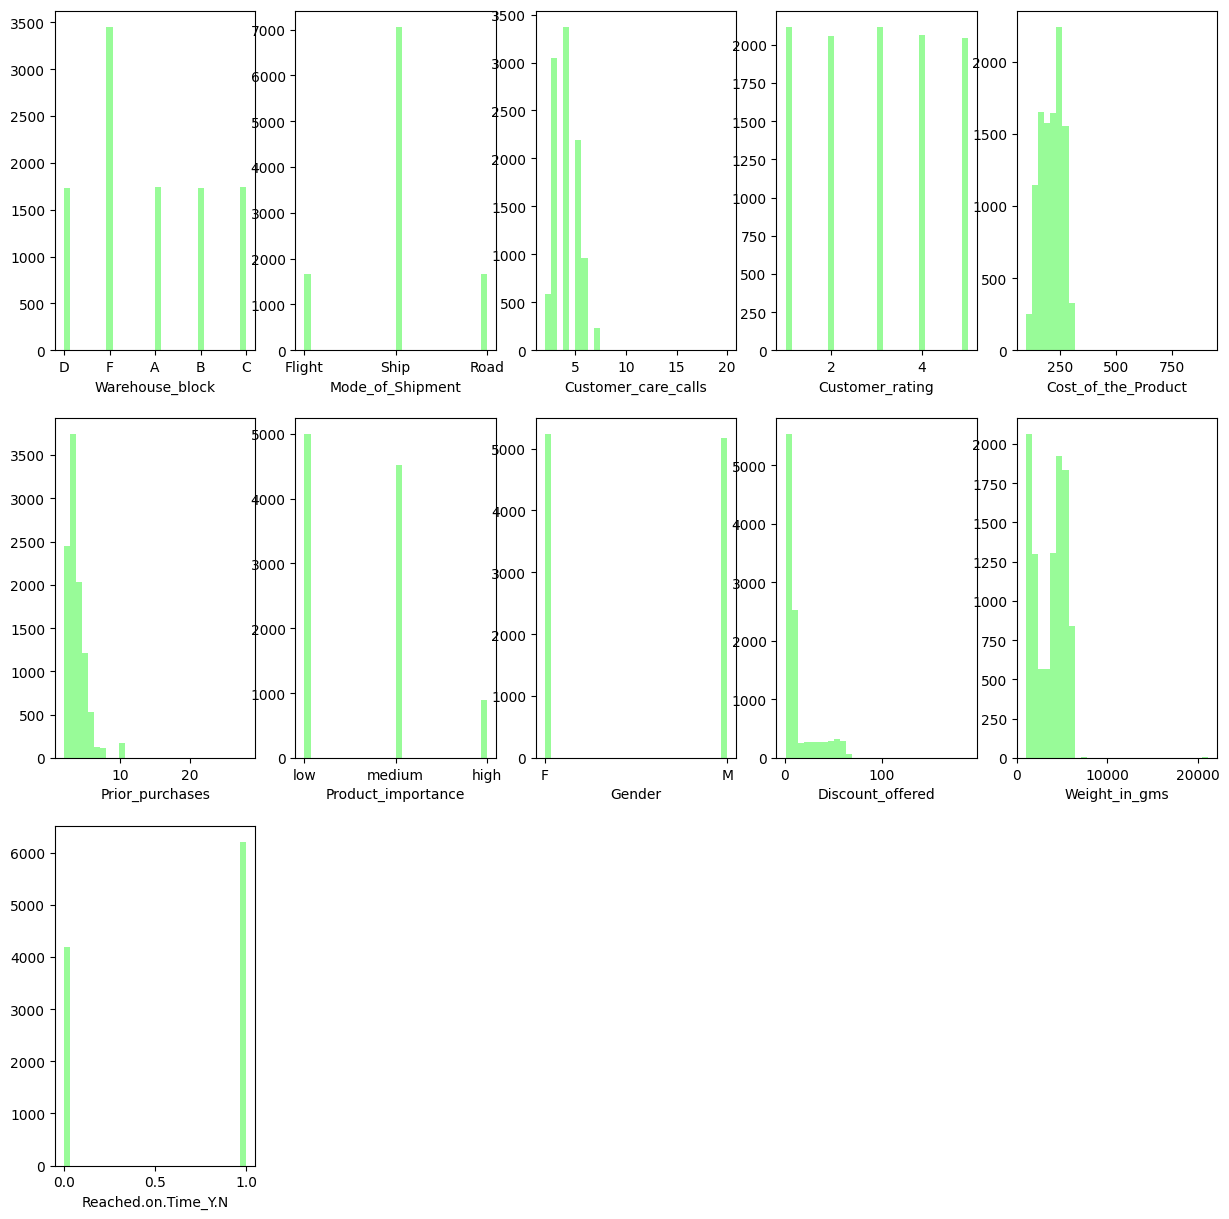

In [13]:
def hist_for_each_col():
  fig = plt.figure(figsize=(15, 15))
  df_for_hist_plot = df.dropna()
  df_columns = df.columns
  for i in range(0, len(df_columns)):
    fig.add_subplot(3, 5, i+1)
    plt.hist(df_for_hist_plot[df_columns[i]], bins=30, color='palegreen')
    plt.xlabel(df_columns[i])
  plt.show()
hist_for_each_col()

Categorical values will be replaced with the most frequent value

Distributions seems like Gaussian distribution will be replaced with mean

And those ones that look like an offset of Gaussian distribution will be replaced with median

In [14]:
# A function to replace outliers with an average using IQR
replace_with_median = ['Customer_care_calls', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
def replace_outliers_iqr(df, columns, func):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
        replacment_value = func(df[col])
        df.loc[outliers, col] = replacment_value

replace_outliers_iqr(df, replace_with_median, np.median) # Apply function

Now NaN values will be replaced with the same logic

In [15]:
replace_with_most_frequent = [x for x in df.columns if x not in replace_with_median]
imr1 = SimpleImputer(missing_values=np.nan, strategy='mean')
imr2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df[replace_with_median] = imr1.fit_transform(df[replace_with_median])
df[replace_with_most_frequent] = imr2.fit_transform(df[replace_with_most_frequent])

In [16]:
# let's again check the number of NaN data
df.isnull().sum()

,0
Warehouse_block,0
Mode_of_Shipment,0
Customer_care_calls,0
Customer_rating,0
Cost_of_the_Product,0
Prior_purchases,0
Product_importance,0
Gender,0
Discount_offered,0
Weight_in_gms,0


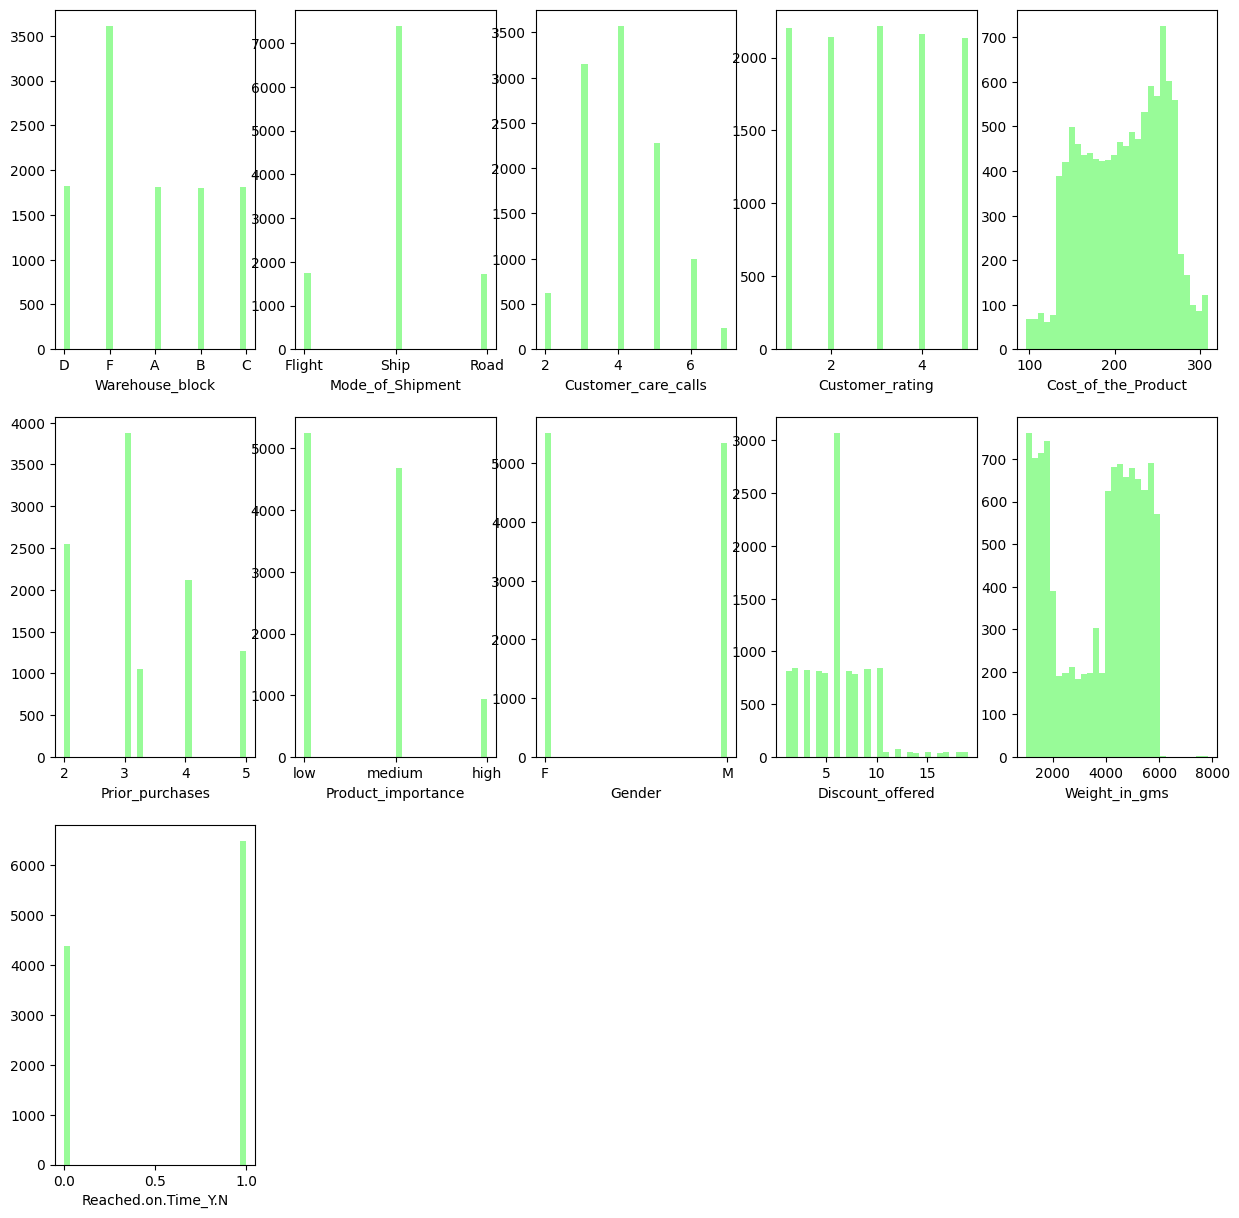

In [17]:
# again check hists for each parametr
hist_for_each_col()

In [18]:
(df['Weight_in_gms'] > 6100).sum()

7

In [19]:
# weights that are bigger than 6100 only 6 let's replace it with 6100
df['Weight_in_gms'] = df['Weight_in_gms'].clip(upper=6100)

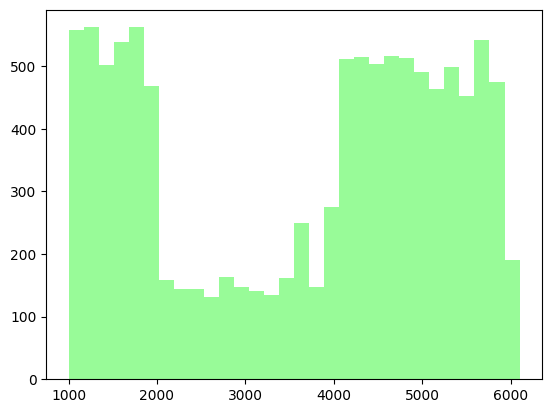

In [20]:
# check Weight_in_gms hist
plt.hist(df['Weight_in_gms'], bins=30, color='palegreen')
plt.show()

# Feature Pairwise Visualization and Dependency Analysis

In [21]:
df_col_for_grapics = list(df.columns)
m = 4
s1 = s2 = 15
def pairwise_feature_visualization(feature_x, color):
  global m, s1, s2
  if((len(df_col_for_grapics)) % 3 == 1):
    m -= 1
    s1 -= 1
    s2 -= 3
  sns.set(style='whitegrid')
  fig, axes = plt.subplots(m, 3, figsize=((s1, s2)))
  fig.suptitle(f'Pairwise Feature Visualization with {feature_x}', fontsize=15)
  axes = axes.flatten()
  for i, feature_y in enumerate([col for col in df_col_for_grapics if col != feature_x]):
    ax = axes[i]
    ax.scatter(df[feature_x], df[feature_y], c=color)
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    ax.grid(True)
  plt.tight_layout(rect=[0, 0, 1, 0.92])
  plt.show()
  df_col_for_grapics.remove(feature_x)


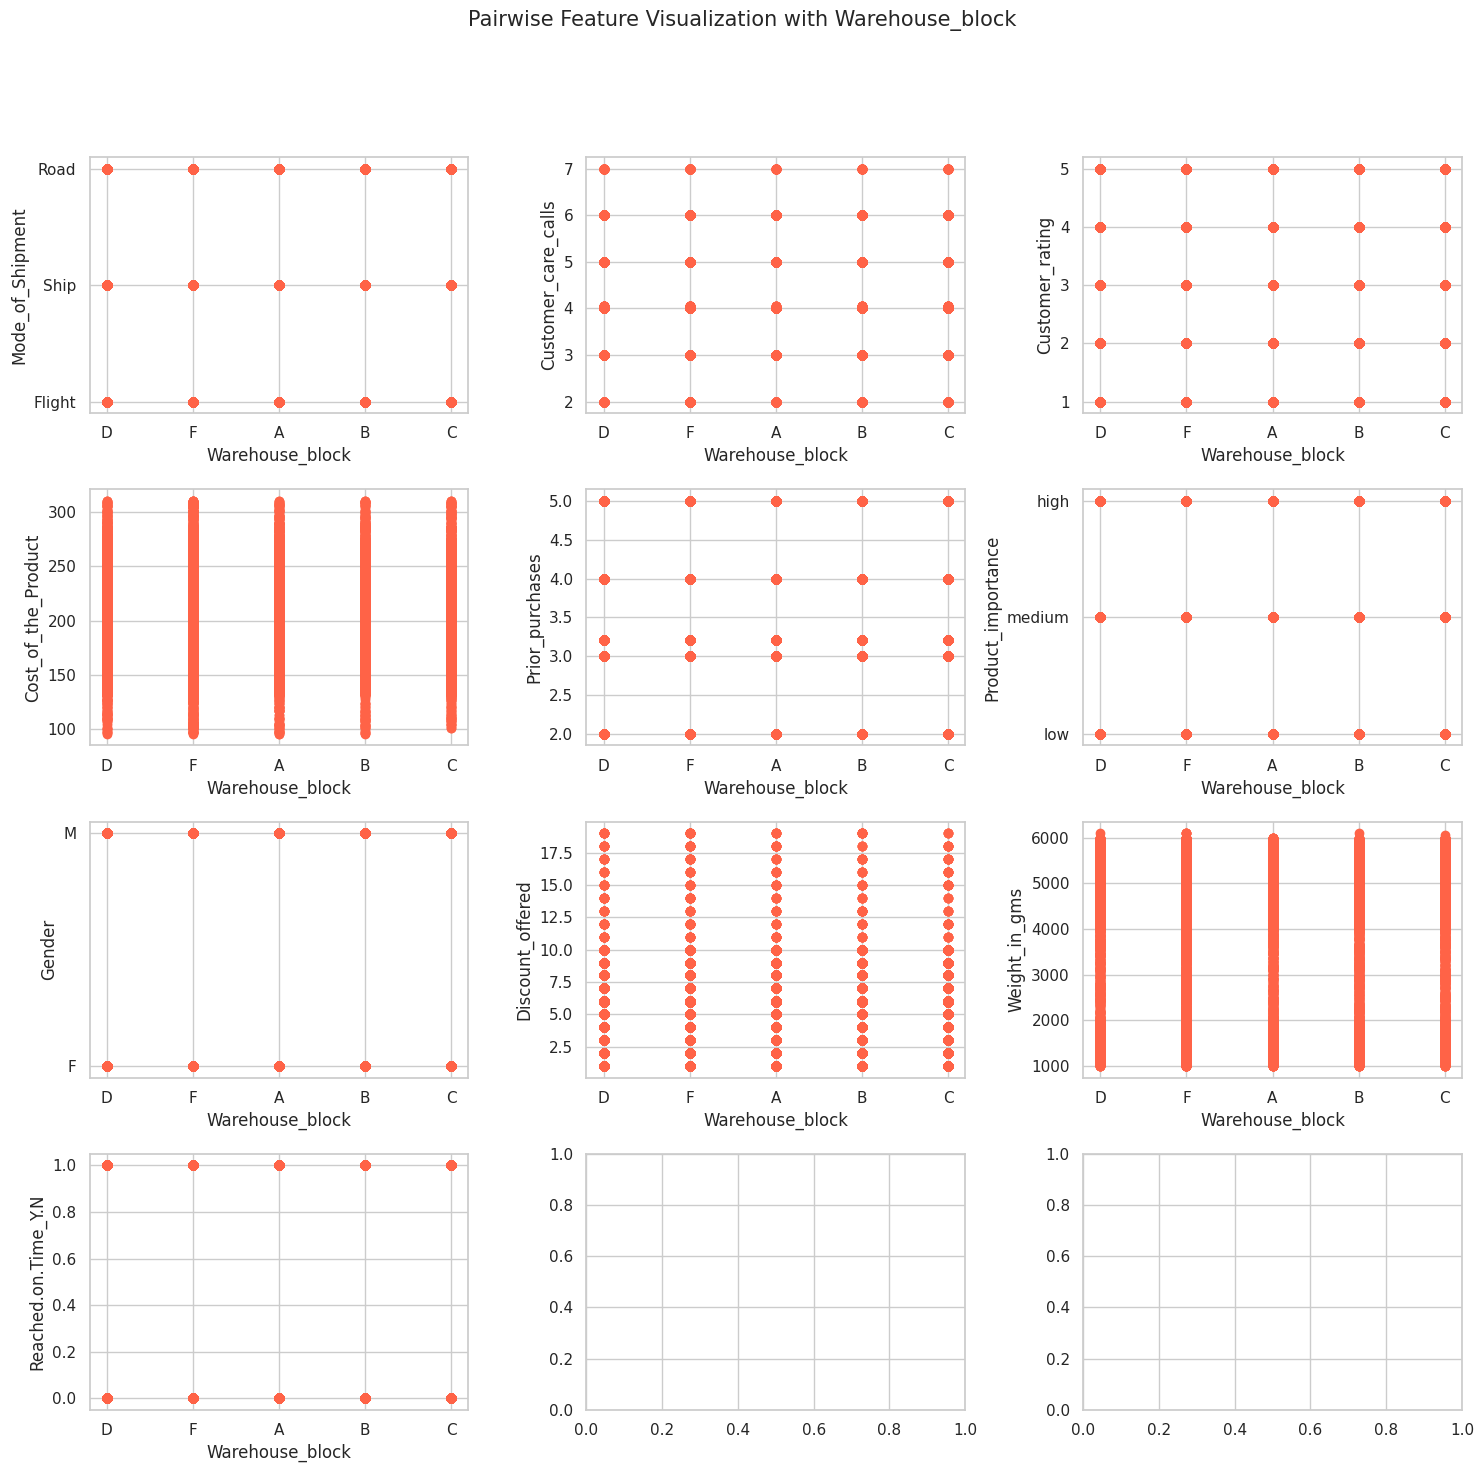

In [22]:
pairwise_feature_visualization('Warehouse_block', 'tomato')

В каждом блок компании примерно одинаковое распределение всех параметров

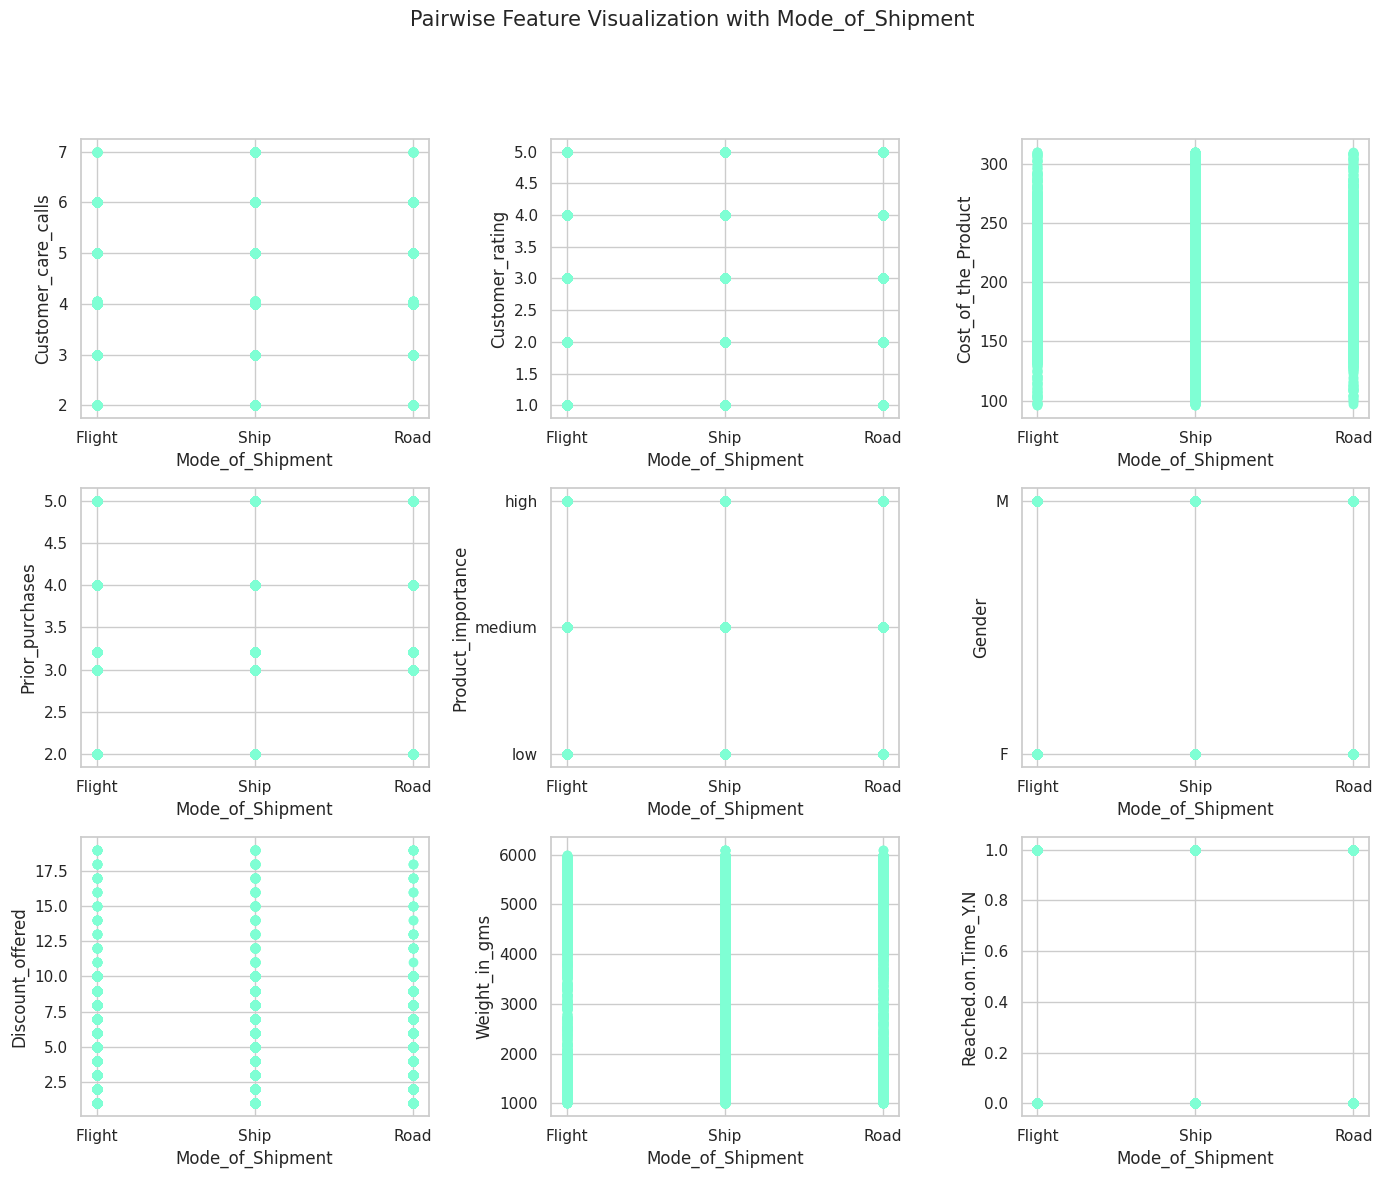

In [23]:
pairwise_feature_visualization('Mode_of_Shipment', 'aquamarine')

Каждый метод доставки ( в том числе и от блока компании из предыдущих графиков) имеет одинаковое распределение остальных параметров.

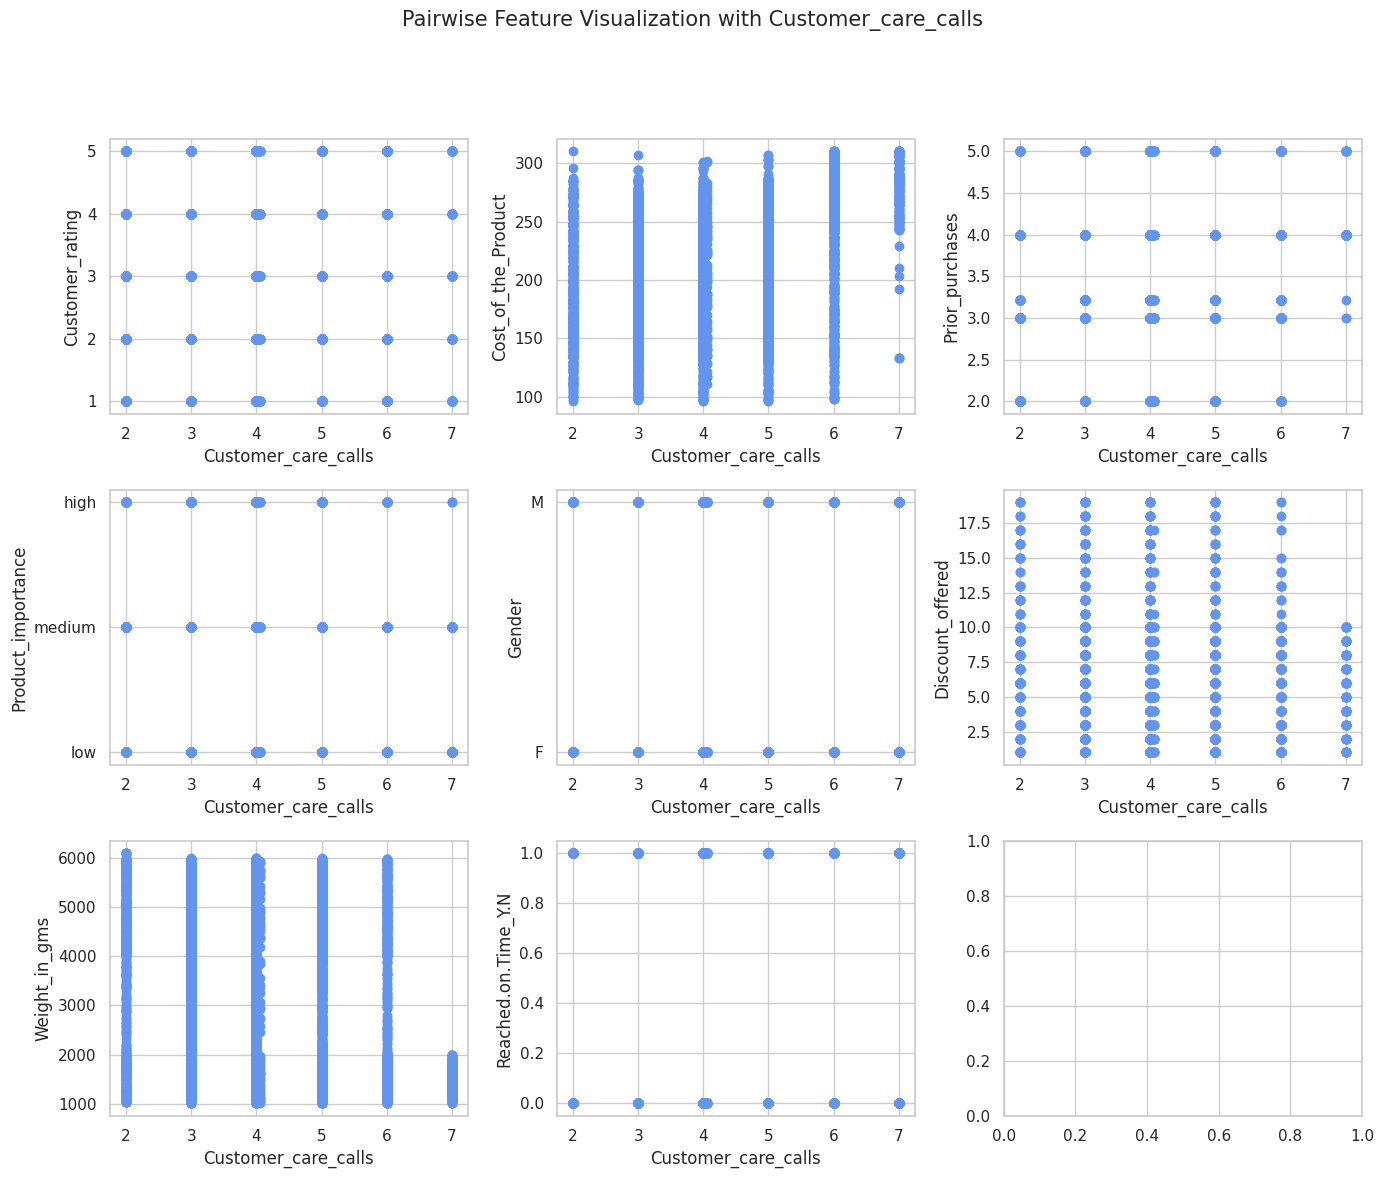

In [24]:
pairwise_feature_visualization('Customer_care_calls', 'cornflowerblue')

В основном люди совершали четыре звонка. А 7 звонков это самое редкое значение.

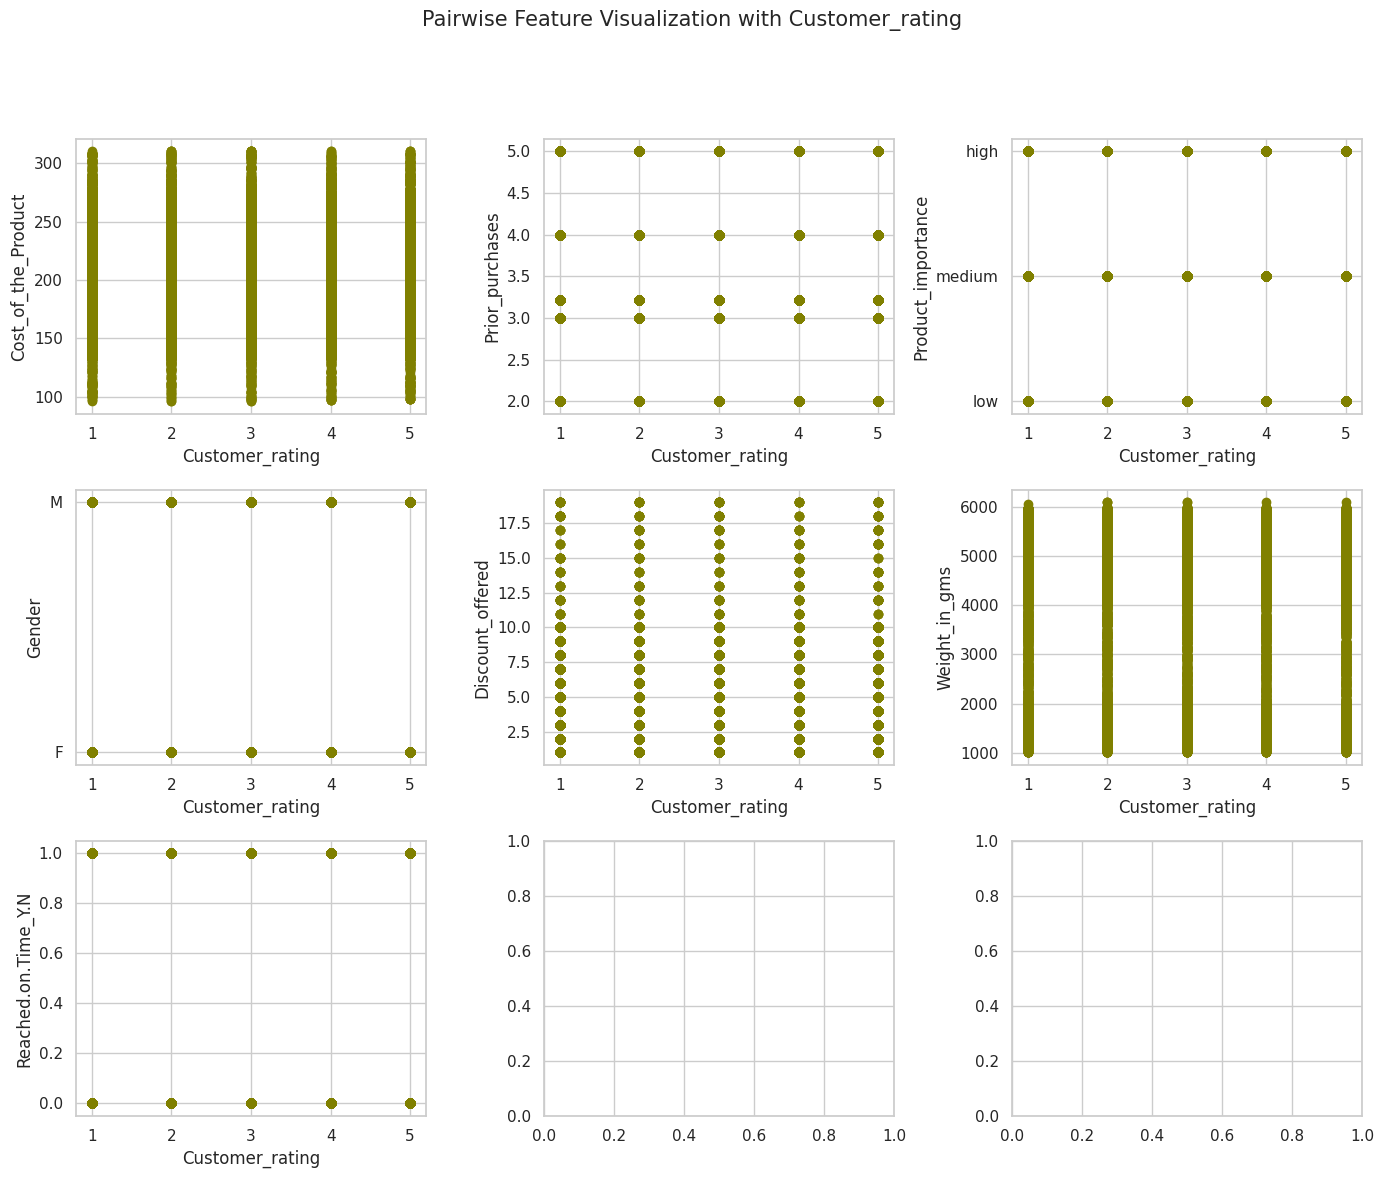

In [25]:
pairwise_feature_visualization('Customer_rating', 'olive')

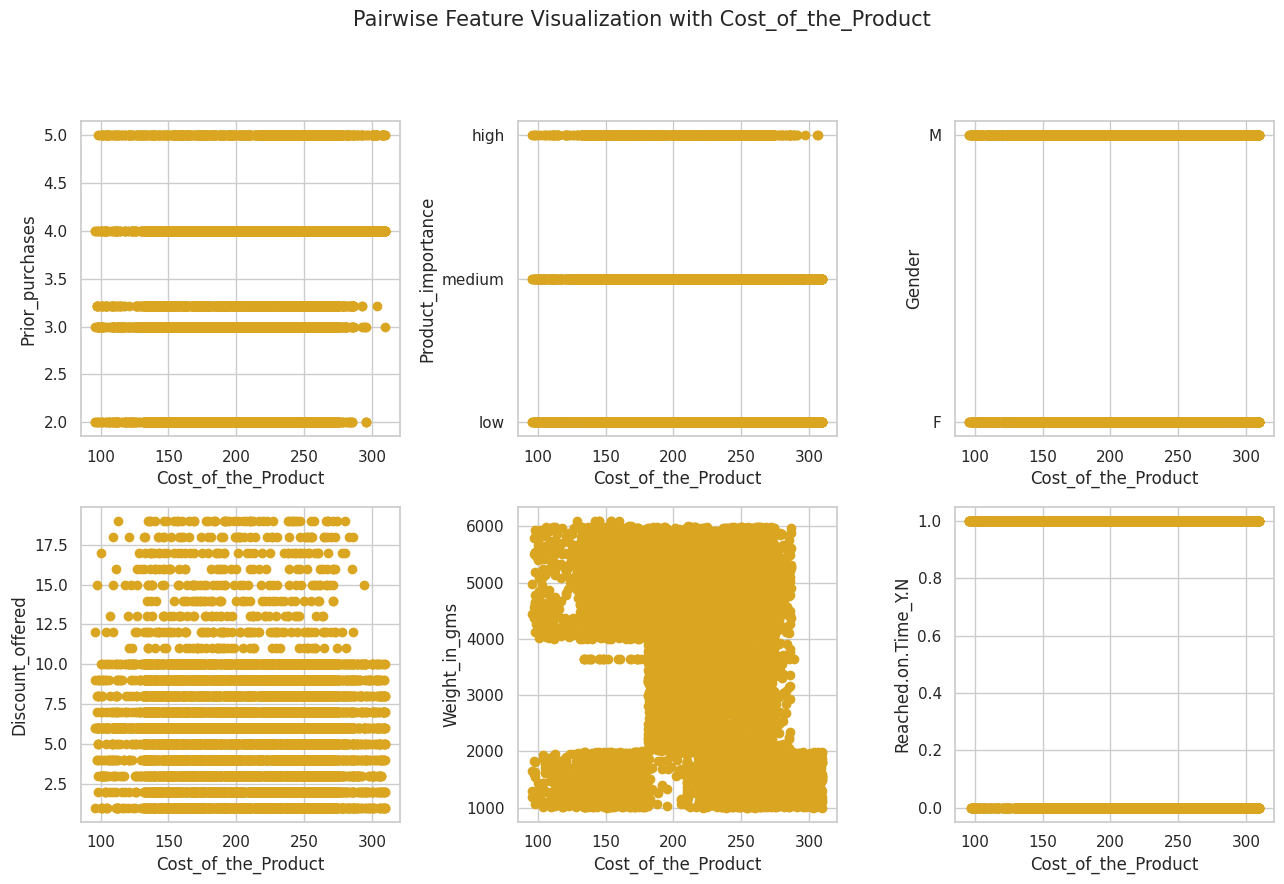

In [26]:
pairwise_feature_visualization('Cost_of_the_Product', 'goldenrod')

Тут тоже все приблизительно равномерно, кроме скидки ( большая скидка соответсвенно всречается реже ) и цена товара от 100 до 160 примерно не соответсвет почти никаким товарам с весом от 2000 до 4000 тысяч

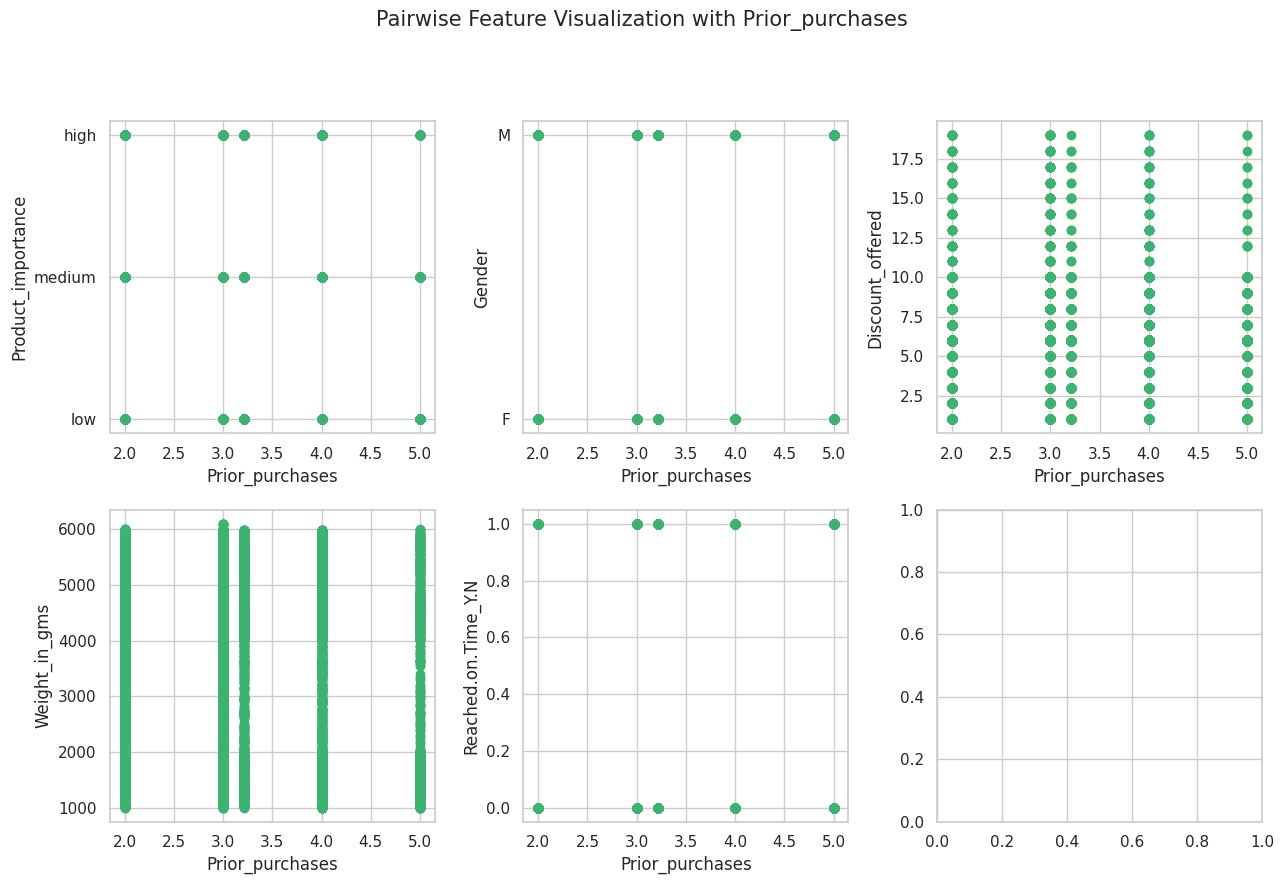

In [27]:
pairwise_feature_visualization('Prior_purchases', 'mediumseagreen')

Можно заметить, что 5 предыдущих покупок перед заказом имело меньшее кол-во людей.

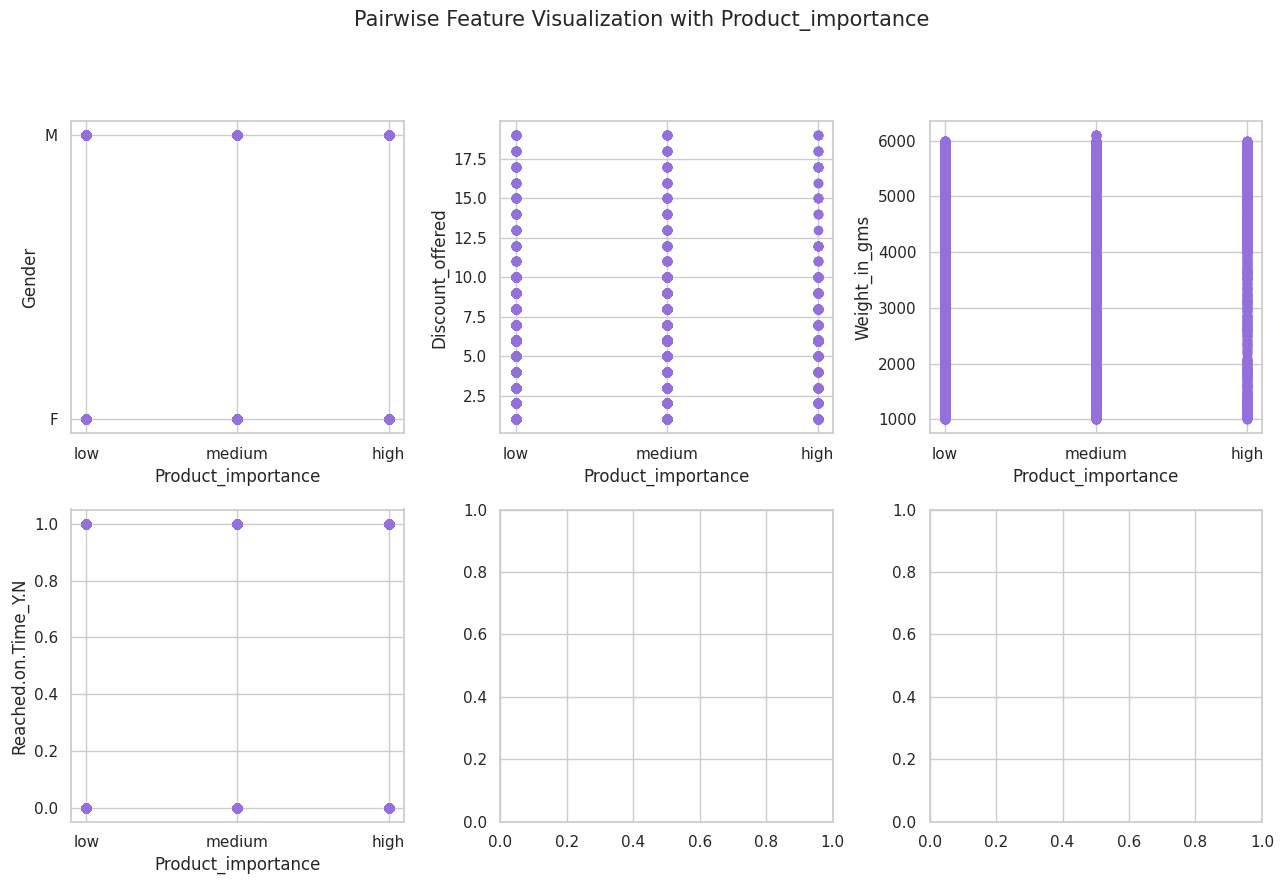

In [28]:
pairwise_feature_visualization('Product_importance', 'mediumpurple')

Тут примерно все равномерно.

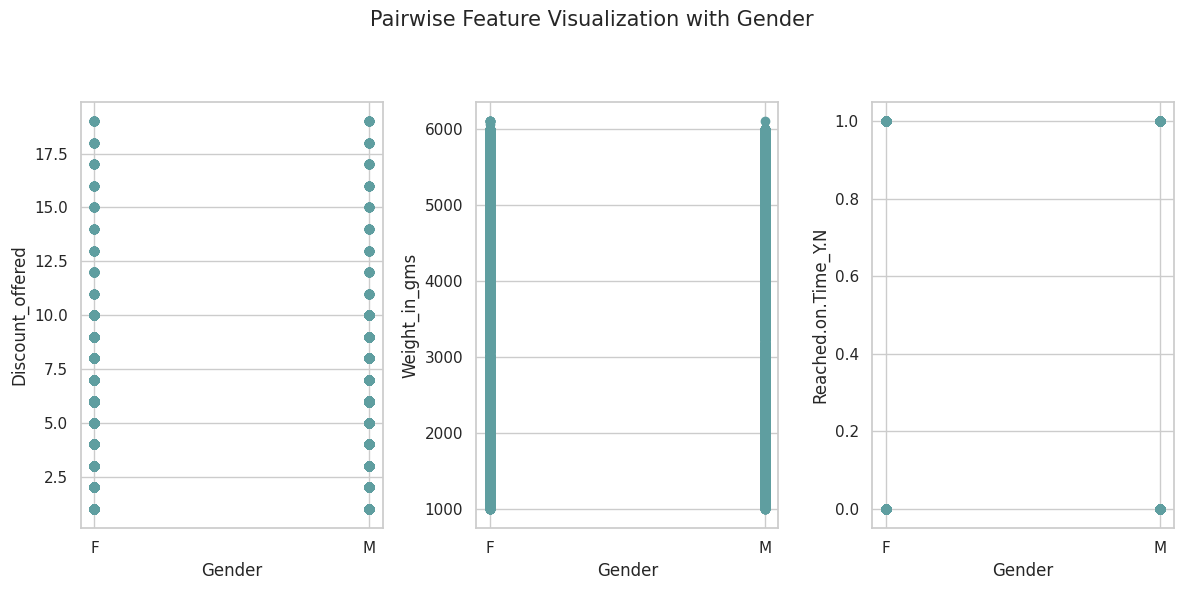

In [29]:
pairwise_feature_visualization('Gender', 'cadetblue')

И тут тоже.

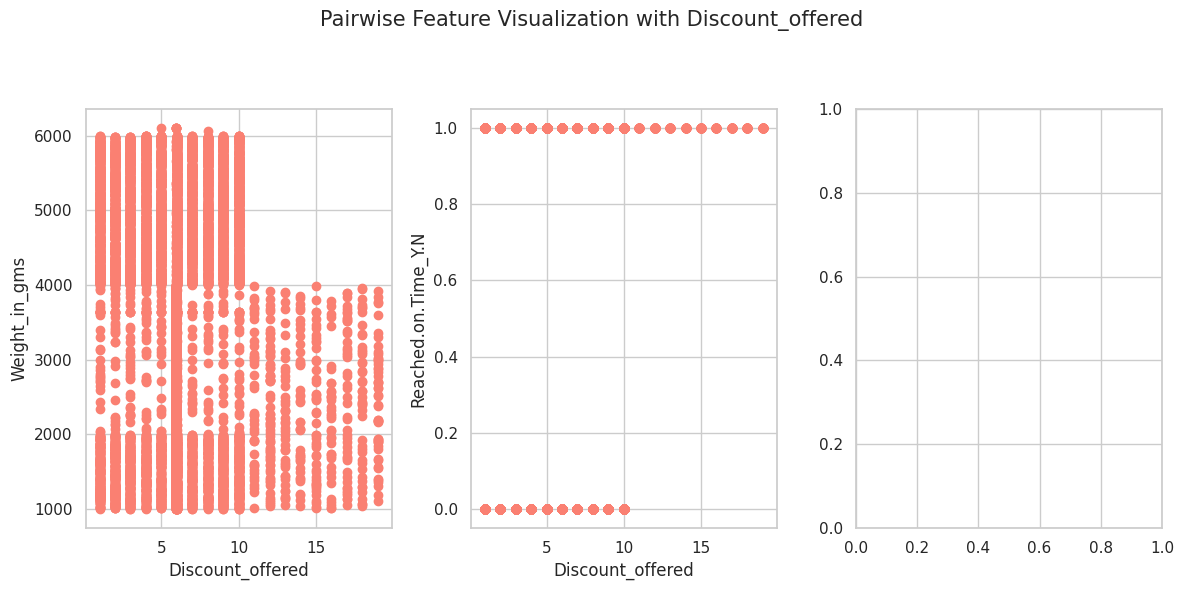

In [30]:
pairwise_feature_visualization('Discount_offered', 'salmon')

Опять же можно увидеть, что большая скидка встречается реже, но также товары с большей скидкой в большинстве прибывали во время.

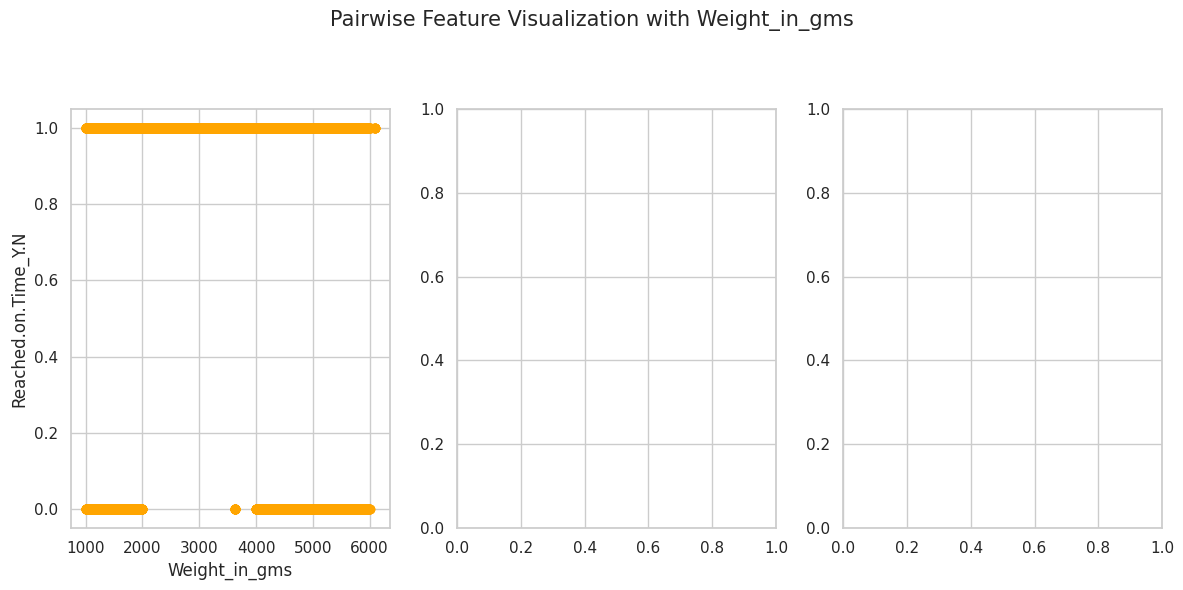

In [31]:
pairwise_feature_visualization('Weight_in_gms', 'orange')

Последний график показывает, что от 2000 до 4000 почти нет товаров, которые приходили позже назначеного срока, скорее всего их просто меньше.

Затем после кодировки категориальных данных получим корреляцию

In [32]:
df_for_corr = df.copy()
categ_cols = ['Warehouse_block', 'Mode_of_Shipment','Customer_rating', 'Product_importance', 'Gender','Reached.on.Time_Y.N']
numeric_cols = [x for x in df_for_corr.columns if x not in categ_cols]
class_le = LabelEncoder()
for col in categ_cols:
    df_for_corr[col] = class_le.fit_transform(df_for_corr[col])
stdsc = StandardScaler()
df_for_corr[numeric_cols] = stdsc.fit_transform(df_for_corr[numeric_cols])
df_for_corr

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,3,0,-0.047152,1,-0.694113,-2.314836e-01,1,0,0.000000,-1.476535,1
1,4,0,-0.047152,4,0.120035,-1.313322e+00,1,1,0.000000,-0.337101,1
2,0,0,-1.807449,1,-0.568860,8.503546e-01,1,1,0.000000,-0.161425,1
3,1,0,-0.927301,2,-0.714989,8.503546e-01,2,1,1.283767,-1.510933,1
4,2,0,-1.807449,1,-0.547984,-2.314836e-01,2,0,0.000000,-0.708108,1
...,...,...,...,...,...,...,...,...,...,...,...
10994,0,2,-0.047152,0,0.871557,1.932193e+00,2,0,-1.582377,-1.289189,1
10995,1,2,-0.047152,0,0.454045,1.932193e+00,2,0,0.009925,-1.467935,0
10996,2,2,0.832996,3,0.662801,1.932193e+00,1,0,-0.626995,-1.524446,0
10997,4,2,0.832996,1,0.266164,4.804327e-16,2,1,-1.263916,-1.490663,0


<Axes: >

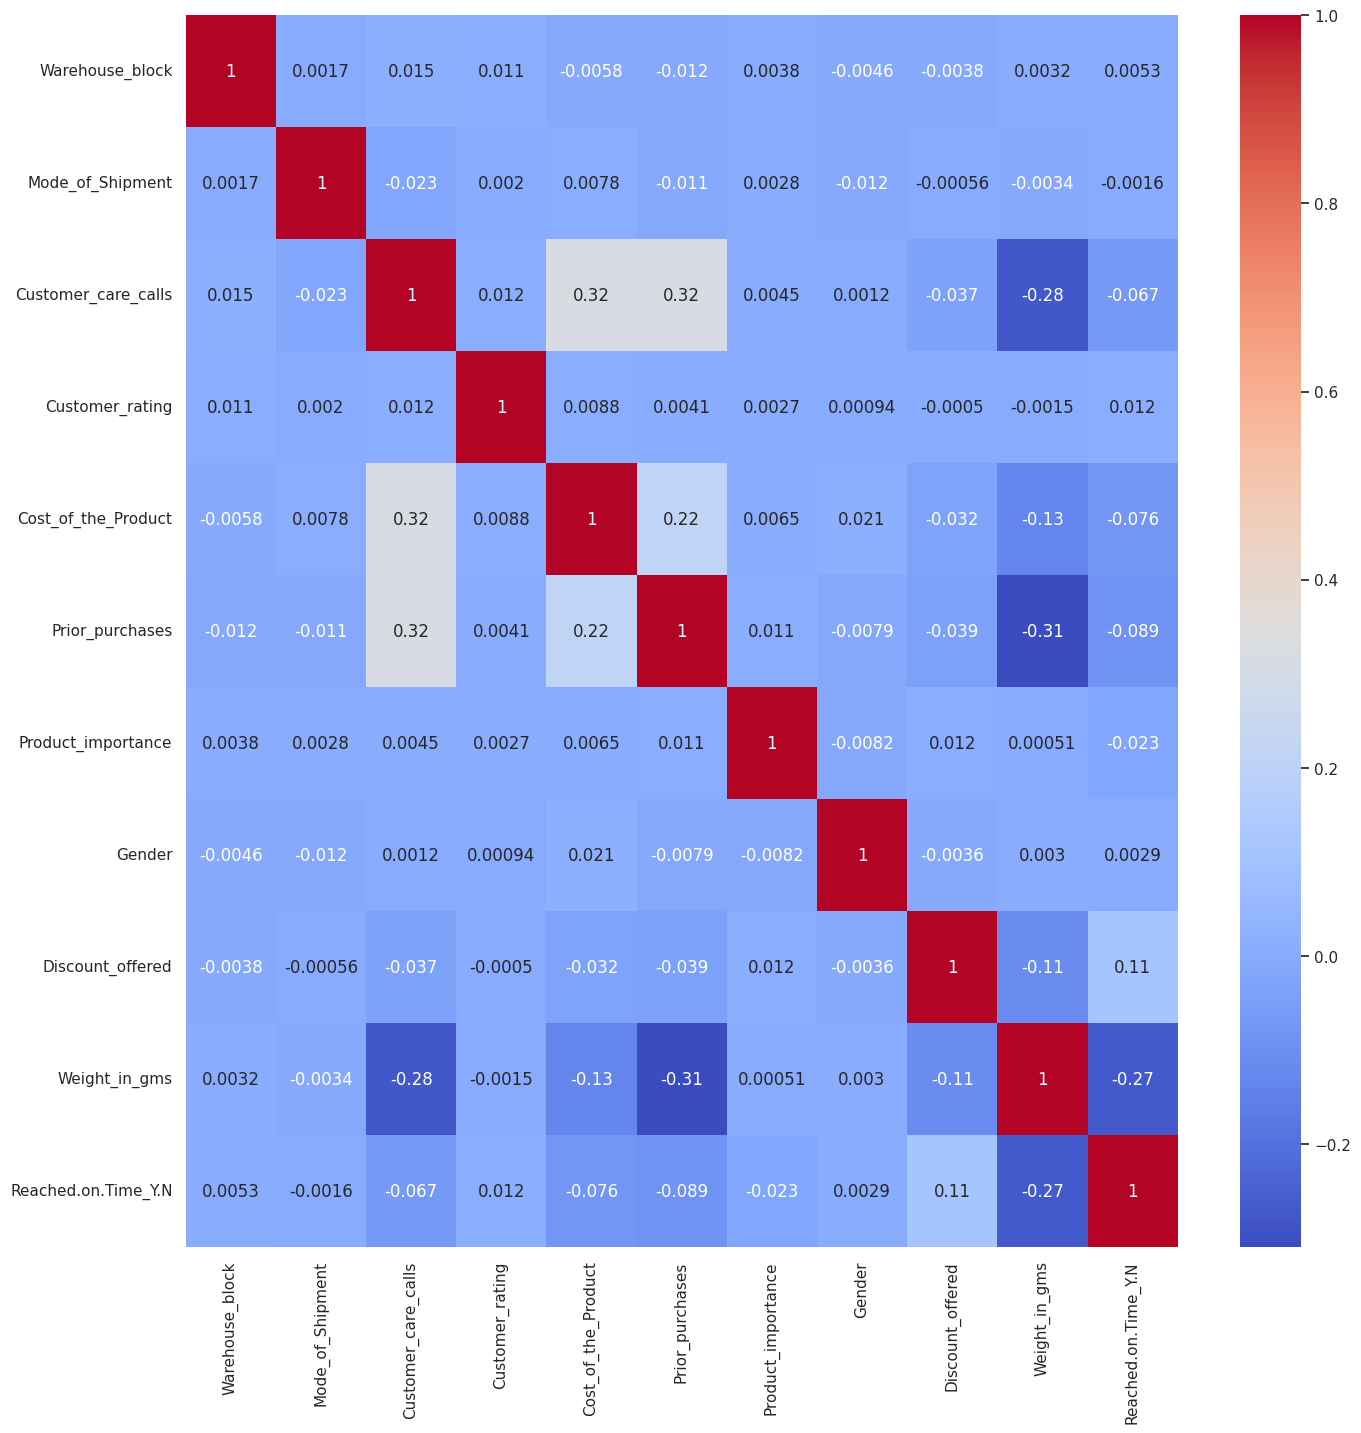

In [33]:
cor_data = pd.DataFrame(df_for_corr, columns=df.columns).corr()
plt.figure(figsize=(16, 16))
sns.heatmap(cor_data, annot=True, cmap='coolwarm')

Здесь можем увидеть корреляцию между коллонками, чем ближе к 1, тем они больше зависят друг от друга. Видим, что чем больше вес товара, тем реже товар доставляется во время, или до этого покупатель меньше заказывал, или он меньше совершал звонков. Но вообще нет нигде особо высокой корреляции.

# Encoding + standardization

In [34]:
categ_cols.remove('Reached.on.Time_Y.N')
df = pd.get_dummies(df, columns=categ_cols, dtype=int)

In [35]:
# standartization
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [36]:
df

,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,...,Customer_rating_1,Customer_rating_2,Customer_rating_3,Customer_rating_4,Customer_rating_5,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
0,-0.047152,-0.694113,-2.314836e-01,0.000000,-1.476535,1,0,0,0,1,...,0,1,0,0,0,0,1,0,1,0
1,-0.047152,0.120035,-1.313322e+00,0.000000,-0.337101,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
2,-1.807449,-0.568860,8.503546e-01,0.000000,-0.161425,1,1,0,0,0,...,0,1,0,0,0,0,1,0,0,1
3,-0.927301,-0.714989,8.503546e-01,1.283767,-1.510933,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
4,-1.807449,-0.547984,-2.314836e-01,0.000000,-0.708108,1,0,0,1,0,...,0,1,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10994,-0.047152,0.871557,1.932193e+00,-1.582377,-1.289189,1,1,0,0,0,...,1,0,0,0,0,0,0,1,1,0
10995,-0.047152,0.454045,1.932193e+00,0.009925,-1.467935,0,0,1,0,0,...,1,0,0,0,0,0,0,1,1,0
10996,0.832996,0.662801,1.932193e+00,-0.626995,-1.524446,0,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0
10997,0.832996,0.266164,4.804327e-16,-1.263916,-1.490663,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1


# Train-Test split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Reached.on.Time_Y.N', axis=1), df['Reached.on.Time_Y.N'], test_size=0.2, random_state=52)

In [38]:
y_test

,Reached.on.Time_Y.N
9156,1
2280,1
1699,1
6297,0
10860,1
...,...
8109,1
1645,1
10244,0
9102,0


In [39]:
X_train

,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,...,Customer_rating_1,Customer_rating_2,Customer_rating_3,Customer_rating_4,Customer_rating_5,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
9077,-0.927301,0.767179,-1.313322,-1.582377,0.371744,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
9008,1.713144,-1.675267,1.932193,-0.945456,1.239065,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
5792,0.832996,0.621050,1.932193,-1.582377,-1.496805,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
1521,-0.047152,1.205567,-0.231484,0.328386,-0.009091,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,1
8775,-0.047152,0.328791,-0.231484,1.283767,1.024692,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9237,-0.047152,0.746303,-1.313322,-1.263916,0.611916,0,1,0,0,0,...,0,0,0,1,0,0,0,1,1,0
4307,-0.047152,-1.570889,-0.231484,0.009925,1.000736,0,0,0,0,1,...,0,0,0,0,1,0,0,1,1,0
7803,-0.047152,1.038562,-0.231484,0.965307,0.369901,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,1
10013,-0.047152,1.163816,-0.231484,1.283767,0.457739,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,1


In [40]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [41]:
X_train.shape

(8688, 23)

# Logistic Regression

In [42]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2', 'l1'],
    'solver': ['liblinear', 'saga']
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid_lr,
    cv=5,
    scoring='accuracy'
)

grid_lr.fit(X_train, y_train)

print(f"Best params: {grid_lr.best_params_}")
print(f"Best cross-valid accuracy: {grid_lr.best_score_:.4f}")

Best params: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
Best cross-valid accuracy: 0.6388


In [43]:
lr = LogisticRegression(max_iter=1000, C=0.01, penalty='l1', solver='saga')
lr.fit(X_train, y_train)
score_lr_train = lr.score(X_train, y_train)
score_lr_test = lr.score(X_test, y_test)

# Support Vector Machines

In [44]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [2, 3, 4]
}

grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy')
grid_svm.fit(X_train, y_train)

print(f"Best params: {grid_svm.best_params_}")
print(f"Best cross-valid accuracy: {grid_svm.best_score_:.4f}")

Best params: {'C': 1, 'degree': 2, 'kernel': 'rbf'}
Best cross-valid accuracy: 0.6625


In [45]:
svm = SVC(C=1, kernel='rbf', degree=2)
svm.fit(X_train, y_train)
score_svm_train = svm.score(X_train, y_train)
score_svm_test = svm.score(X_test, y_test)

# Random Forests

In [46]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)

print(f"Best params: {grid_rf.best_params_}")
print(f"Best cross-valid accuracy: {grid_rf.best_score_:.4f}")

Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-valid accuracy: 0.6733


In [47]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=2, min_samples_split=10)
rf.fit(X_train, y_train)
score_rf_train = rf.score(X_train, y_train)
score_rf_test = rf.score(X_test, y_test)

# Evaluate the accuracy

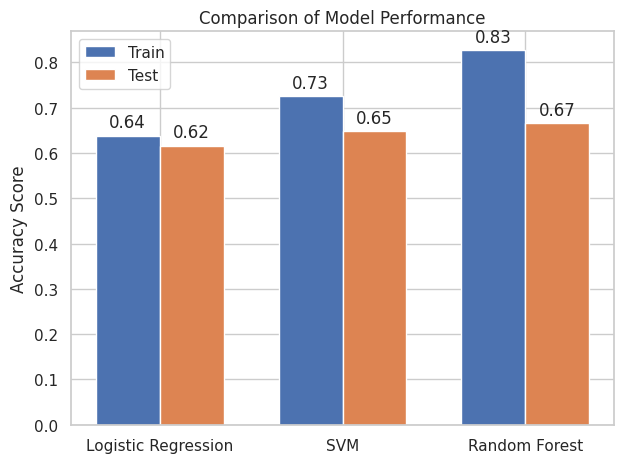

In [48]:
scores = {
    'Logistic Regression': [score_lr_train, score_lr_test],
    'SVM': [score_svm_train, score_svm_test],
    'Random Forest': [score_rf_train, score_rf_test]
}

models = list(scores.keys())
train_scores = [score[0] for score in scores.values()]
test_scores = [score[1] for score in scores.values()]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()

rects1 = ax.bar(x - width / 2, train_scores, width, label='Train')
rects2 = ax.bar(x + width / 2, test_scores, width, label='Test')

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

ax.set_ylabel('Accuracy Score')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()

Как видим лучшие параметры показала модель Random Forest, правда в ней точность на тренировочных данных больше, что указывает на переобучение. Также переобучкние есть и в Support Vector Machines. В самой худшей модели Logistic Regression у нас точность на тренировочных и тестовых данных вообще не отличается. Из низкого качества предсказаний следует, что данные не линейно разделимы.

# Dimensionality reduction

In [49]:
# 1. L1-regularization (Logistic Regression with L1 penalty)
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=1)
lasso_model.fit(X_train, y_train)

# Prediction
lasso_pred = lasso_model.predict(X_test)

# Calculating accuracy
lasso_accuracy = accuracy_score(y_test, lasso_pred)

# Feature selection: those features that have a non-zero coefficient
lasso_selected_features = np.where(lasso_model.coef_[0] != 0)[0]

In [55]:
X_train_np = X_train.values if hasattr(X_train, "values") else X_train
X_test_np = X_test.values if hasattr(X_test, "values") else X_test
# 2. Sequential Feature Selector
# applying SFS with Logistic Regression
selector = SequentialFeatureSelector(LogisticRegression(penalty=None), n_features_to_select='auto', direction='forward')
selector.fit(X_train_np, y_train)

# Feature selection
selected_features_sfs = selector.get_support(indices=True)

# Calculating accuracy with logistic Regression in order to the model was the same
X_test_selected = X_test_np[:, selected_features_sfs]
sfs_model = LogisticRegression(penalty=None)
sfs_model.fit(X_train_np[:, selected_features_sfs], y_train)
sfs_pred = sfs_model.predict(X_test_selected)
sfs_accuracy = accuracy_score(y_test, sfs_pred)

In [51]:
# 3. Decision Tree
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)

# Accuracy
tree_accuracy = accuracy_score(y_test, tree_pred)

In [56]:
# Results
print(f"Lasso Accuracy: {lasso_accuracy:.4f}")
print(f"Feature selection L-1 regularization: {lasso_selected_features}")
print(f"SFS Accuracy: {sfs_accuracy:.4f}")
print(f"Feature selection SFS: {selected_features_sfs}")
print(f"Decision Tree Accuracy: {tree_accuracy:.4f}")

Lasso Accuracy: 0.6206
Feature selection L-1 regularization: [ 0  1  2  3  4  5  6  7  8 10 12 14 15 16 17 18 20 22]
SFS Accuracy: 0.6381
Feature selection SFS: [ 4  5  7  8 11 13 14 15 16 17 18]
Decision Tree Accuracy: 0.6331


Видим, что L-1 regularization и SFS выбирают разные призаки, хотя видно что SFS содержит теже, что и L-1 regularization, но просто больше. А точность у всех приблизительно одинаковая.